# Symulacja Monte Carlo

Symulacja Monte Carlo to technika probabilistyczna służąca do modelowania niepewności i podejmowania decyzji w warunkach ryzyka. Polega na wielokrotnym losowym próbkowaniu zmiennych wejściowych w celu uzyskania rozkładu możliwych wyników.

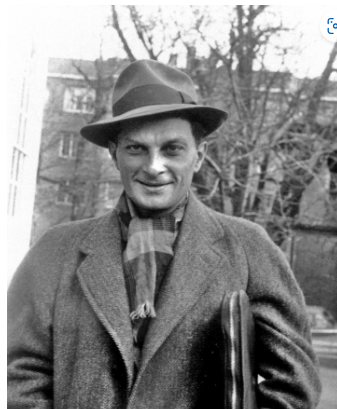

**Stanisław Ulam (1909-1984)**
https://www.imdb.com/title/tt6875374/

## Expected Shortfall dla strat z rozkładu t-Studenta (Analityczna forma)

$$
\text{ES}_\alpha(L) = \mu + \sigma \cdot \frac{\nu + \left( t_\alpha \right)^2}{\nu - 1} \cdot \frac{f_{t,\nu}(t_\alpha)}{1 - \alpha}
$$

### Gdzie:
- $\alpha \in (0, 1)$ – poziom istotności (np. 0.05),
- $t_\alpha = T^{-1}(\alpha)$ – kwantyl standardowego rozkładu t-Studenta o $\nu$ stopniach swobody,
- $f_{t,\nu}(t_\alpha)$ – gęstość standardowego rozkładu t-Studenta w punkcie $t_\alpha$:

$$
f_{t,\nu}(x) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu}} \cdot \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu + 1}{2}}
$$

### Gdzie:
- $x$ – punkt, w którym liczona jest gęstość,
- $\nu$ – liczba stopni swobody,
- $\Gamma(\cdot)$ – funkcja gamma (uogólnienie silni dla liczb rzeczywistych).


In [ ]:
#Pobranie danych
import yfinance as yf
import numpy as np

data_portfolio = yf.download(['GS', 'JPM', 'AAPL'], period='1y')['Close'].dropna()
stocks = [20, 35, 40]
portfolio = (data_portfolio*stocks).sum(axis=1)
portfolio_log = np.log(portfolio/portfolio.shift(1)).dropna()

In [ ]:
# Symulacja Monte Carlo - Kod z poprzednich zajęć
from scipy.stats import t
df, loc, scale = t.fit(portfolio_log)
alpha = 0.01
samples = t.rvs(df, loc = loc, scale = scale, size = 100000)
VaR_t = np.quantile(samples, alpha)
ES_t = samples[samples <= VaR_t].mean()
ES_t

In [ ]:
# Liczenie zgodnie ze wzorem (VaR Analityczny)
from scipy.special import gamma

def expected_shortfall_t_minus(alpha, mu, sigma, nu):
    t_alpha = t.ppf(alpha, df=nu)
    coef = gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * nu))
    density = coef * (1 + t_alpha**2 / nu) ** (-(nu + 1) / 2)
    es = mu + sigma * ((nu + t_alpha**2) / (nu - 1)) * (density / alpha)
    return -es

alpha = 0.01
es = expected_shortfall_t_minus(alpha, loc, scale, df)
es

In [ ]:
## Użyteczność monte carlo
import plotly.graph_objects as go

S0 = 31441
n_steps = 252         
n_paths = 100       

df, loc, scale = t.fit(portfolio_log)
log_returns = t.rvs(df, loc=loc, scale=scale, size=(n_paths, n_steps))
log_price_paths = np.cumsum(log_returns, axis=1)


price_paths = S0 * np.exp(log_price_paths)
price_paths2 = price_paths

price_paths = np.hstack([np.full((n_paths, 1), S0), price_paths])


time = np.arange(n_steps + 1)


fig = go.Figure()

for i in range(n_paths):
    fig.add_trace(go.Scatter(x=time, y=price_paths[i],
                             mode='lines',
                             line=dict(width=1),
                             opacity=0.7,
                             showlegend=False))

fig.update_layout(
    title='Symulowane ścieżki cen akcji (rozkład t-Studenta)',
    xaxis_title='Dzień',
    yaxis_title='Cena akcji',
    template='plotly_dark',
    height=600
)

fig.show()


In [ ]:
#Moje symulacje dla 252 dni z dystrybucji którą zmierzyłem
import pandas as pd
pd.DataFrame(price_paths).sort_values(251, ascending = False)

In [ ]:
# Moje symulacje dla zwrotów
pd.DataFrame(log_price_paths).sort_values(251, ascending = False)

---

# VaR w Bankach

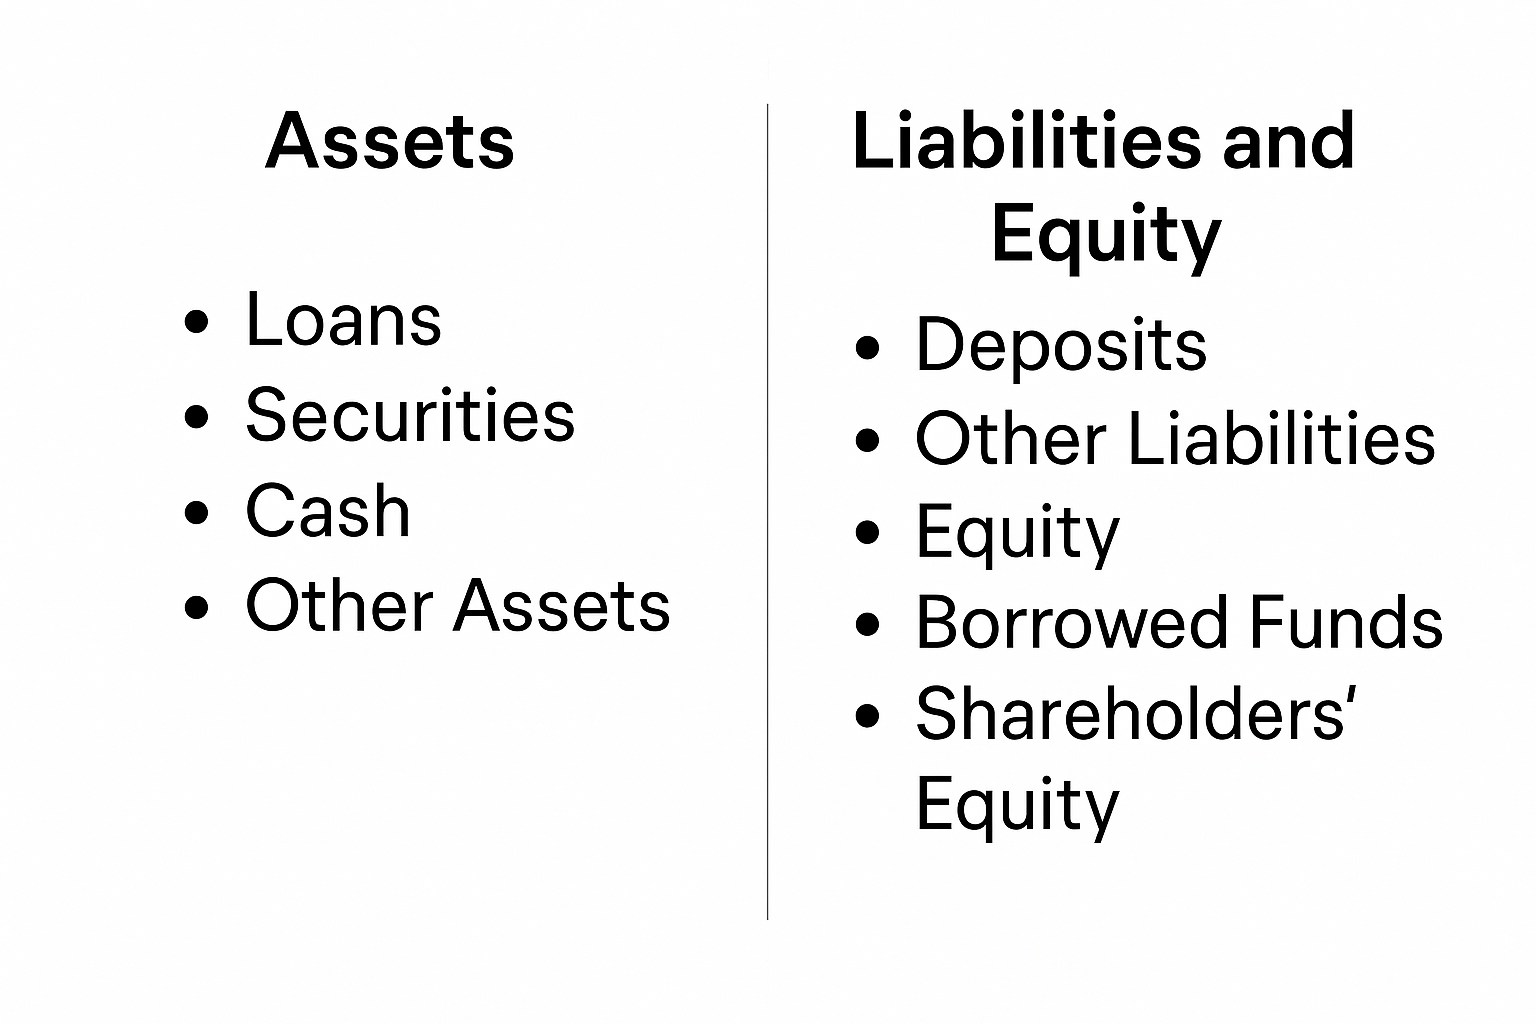

# Działalnośc banku jest sprowadzona do podziału na dwie księgi:
1) Bankową - Zawiera aktywa i pasywa utrzymywane w celu przynoszenia odsetek, bez intencji ich sprzedaży w krótkim terminie.
2) Handlową - Zawiera wszystkie instrumenty finansowe przeznaczone do krótkoterminowego obrotu lub które są przedmiotem aktywnych strategii handlowych, hedgingowych, arbitrażowych lub spekulacyjnych

# Ryzyka co do których bank musi utrzymywać wymogi kapitałowe to:
1) Kredytowe (Głównie Księga Bankowa)
2) Operacyjne (Na poziomie banku)
3) Rynkowe (Księga Handlowa)

# Każde z tych ryzyk może być mierzone za pomocą różnych podejść:
Ryzyko Kredytowe:
* Standardized Approach (SA)	Wagi ryzyka zależne od ratingów zewnętrznych (np. S&P, Moody’s) i klasy ekspozycji.
* Foundation IRB (F-IRB)	Bank sam estymuje PD (Probability of Default), a LGD, EAD – z góry ustalone przez nadzór.
* Advanced IRB (A-IRB)	Bank estymuje wszystkie parametry ryzyka: PD, LGD, EAD, M. Wymaga zgody nadzoru.

Ryzyko Rynkowe:
* Standardized Approach (SA-MR)	Z góry ustalone wagi i szoki rynkowe dla poszczególnych klas instrumentów.
* Internal Models Approach (IMA)	Bank stosuje własny model VaR / sVaR (Basel II.5) lub Expected Shortfall (FRTB). Wymaga zgody nadzoru.
* FRTB-SA / FRTB-IMA	Podejścia zgodne z nowym standardem Basel IV/ III: ES zamiast VaR, desk-level approval.

Ryzyko Operacyjne:
* Basic Indicator Approach (BIA)	Kapitał = % dochodu brutto (np. 15%). Prosty, konserwatywny.
* Standardized Approach (TSA)	Dochód brutto dzielony na segmenty działalności, różne wagi.
* Advanced Measurement Approach (AMA)	Modelowanie ryzyka operacyjnego na podstawie danych własnych. Wycofany w Basel III.
* SMA (Standardised Measurement Approach)	Obowiązujący w Basel III. Uproszczony, oparty na BIA + wskaźniki historycznych strat.

**Każdy z tych sposobów pozwala nam oszacować Risk Charge - kwotowa wartość kapitału, jaką bank musi utrzymywać, aby zabezpieczyć się przed potencjalnymi stratami wynikającymi z określonego rodzaju ryzyka.**

## Market Risk Charge – Basel II.5 (Powoli nieaktualny)

Market Risk Charge (kapitał regulacyjny z tytułu ryzyka rynkowego) w podejściu opartym na modelach wewnętrznych składa się z dwóch komponentów:

- **Value-at-Risk (VaR)** – mierzy bieżące ryzyko rynkowe portfela,
- **Stressed VaR (sVaR)** – mierzy ryzyko rynkowe przy założeniu historycznie stresowych warunków rynkowych.

Wzór kapitałowego wymogu na ryzyko rynkowe:

$$
\text{Market Risk Charge} = 
\max\left(\text{VaR}_{t-1},\ m \cdot \overline{\text{VaR}} \right) + 
\max\left(\text{sVaR}_{t-1},\ m \cdot \overline{\text{sVaR}} \right)
$$

### Gdzie:
- $ \text{VaR}_{t-1} $ –  Wartość 10-dniowego VaR przy poziomie ufności 99% z poprzedniego obliczenia,
- $ \overline{\text{VaR}} $ – średnia wartość VaR z ostatnich 60 dni,
- $ \text{sVaR}_{t-1} $ – Wartość 10-dniowego **Stressed VaR** (z danych historycznych z okresu stresowego) z poprzedniego obliczenia,
- $ \overline{\text{sVaR}} $ – średnia wartość sVaR z ostatnich 60 dni,
- $ m $ – **mnożnik nadzorczy**, ustalany przez regulatora ($ m \geq 3 $, może być zwiększany do 4 w zależności od wyników backtestingu).

- Wymóg ma **charakter konserwatywny** – bazuje na bieżącym i średnim ryzyku,
- sVaR musi być oparty na danych z co najmniej 12-miesięcznego okresu stresowego,
- Market Risk Charge nie obejmuje komponentów **IRC (default risk)**

Więcej możecie znaleźć tu: https://www.bis.org/publ/bcbs158.pdf

## Basel II.5 – Value-at-Risk (VaR) – Wymogi

- **Częstotliwość kalkulacji**: codziennie (daily).
- **Poziom ufności**: jednostronny 99. percentyl.
- **Okres utrzymania pozycji (holding period)**: 10 dni roboczych.
  - Dopuszczalne przeskalowanie z krótszych okresów, np. przez pierwiastek z czasu.
  - Metodologia skalowania musi być uzasadniana wobec nadzorcy.

### Dane historyczne

- **Minimalna długość próby**: 1 rok.
- **Nadzorca** może skrócić okres obserwacji przy zwiększonej zmienności.

### Modele VaR

- Dozwolone różne metody np: 
  - macierze kowariancji (Metoda Delta-Normal),
  - symulacja historyczna,
  - symulacja Monte Carlo.
- Warunek: model musi uchwycić wszystkie istotne ryzyka.

### Stressed VaR

- Dodatkowa miara oparta na historycznym okresie stresu (12 miesięcy):
  - 10-dniowy holding period,
  - 99% jednostronny przedział ufności,
  - Okres stresu zatwierdzany przez nadzorcę.
- Obliczany **minimum raz w tygodniu**.
- Możliwość stosowania alternatywnych metod (np. dane antytetyczne, absolutne zmienności).

https://www.bis.org/publ/bcbs158.pdf (Strona 19-21)

## 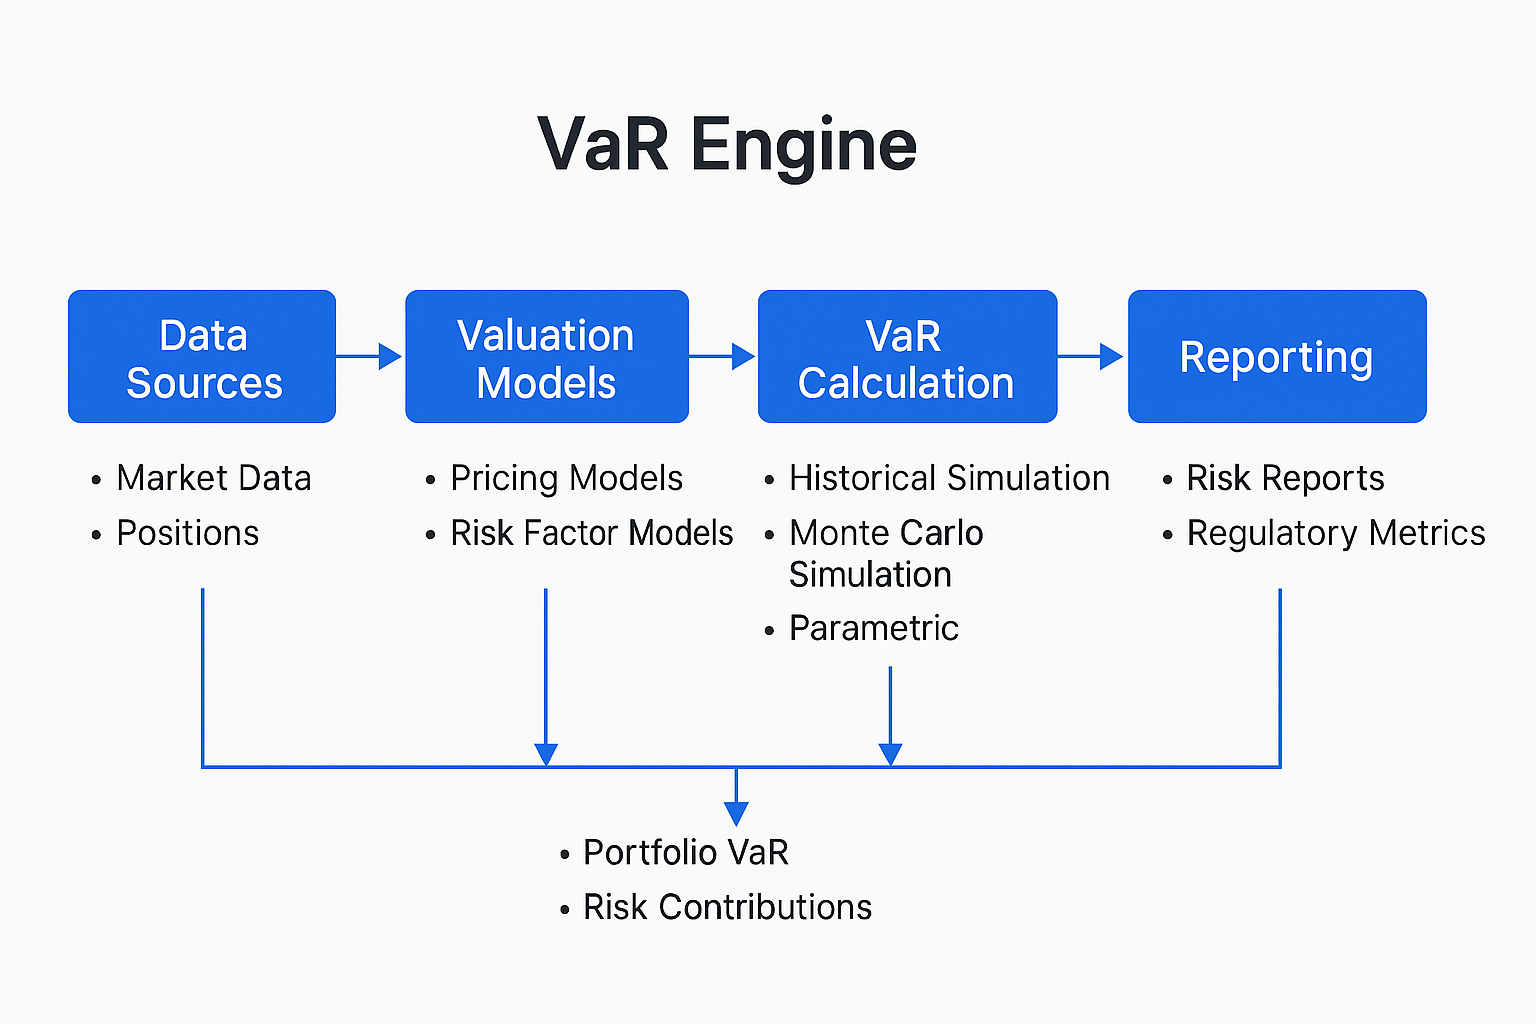

## Historyczna symulacja

In [ ]:
# Import akcji
import yfinance as yf
import pandas as pd
import numpy as np

In [ ]:
# w dzisiejszym portfelu mam 10 akcji  5 ameykańskich i 5 europejskich 
tickers_usd = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
tickers_eur = ['SIE.DE', 'AIR.PA', 'SAN.PA', 'BAS.DE', 'IBE.MC']
ticker_currency = ['EURUSD=X'] # Zakładamy że raportowanie następuje w EURUSD

# Przygotowanie informacji
portfolio_stock_tickers = tickers_usd+tickers_eur
portfolio_tickers = tickers_usd+tickers_eur+ticker_currency

money_invested_usd = [5000, 10000, 2000, 3500, 1000]
money_invested_eur = [2500, 4500, 7000, 3000, 1000]

money_invested = money_invested_usd+money_invested_eur


In [ ]:
# Nasz bank raportuje w EUR

# Okres stresowy
stress_start = '2020-03-12'
stress_end = '2021-04-12'

historical_start = '2024-03-11'
historical_end = '2025-04-11'

#Dane
data_stress = yf.download(portfolio_tickers, start=stress_start, end=stress_end)['Close']
data_historical = yf.download(portfolio_tickers, start=historical_start, end=historical_end)['Close']


In [ ]:
# Kalkulacja zwrotów



In [ ]:
# Historyczna symulacja


In [ ]:
# Wyświetlenie tabeli


In [ ]:
# Kalkulacja VaR


In [ ]:
# To samo tylko dla historycznego stress VaR


In [ ]:
# Wyświetlenie tabeli

In [ ]:
# SVaR


Wzór kapitałowego wymogu na ryzyko rynkowe:

$$
\text{Market Risk Charge} = 
\max\left(\text{VaR}_{t-1},\ m \cdot \overline{\text{VaR}} \right) + 
\max\left(\text{sVaR}_{t-1},\ m \cdot \overline{\text{sVaR}} \right)
$$

### Gdzie:
- $ \text{VaR}_{t-1} $ –  Wartość 10-dniowego VaR przy poziomie ufności 99% z poprzedniego obliczenia,
- $ \overline{\text{VaR}} $ – średnia wartość VaR z ostatnich 60 dni,
- $ \text{sVaR}_{t-1} $ – Wartość 10-dniowego **Stressed VaR** (z danych historycznych z okresu stresowego) z poprzedniego obliczenia,
- $ \overline{\text{sVaR}} $ – średnia wartość sVaR z ostatnich 60 dni,

# Backtest

In [ ]:
data_portfolio = yf.download(['GS', 'JPM', 'AAPL'], period='2y')['Close'].dropna()
stocks = [20, 35, 40]
portfolio = (data_portfolio*stocks).sum(axis=1)
portfolio_log = np.log(portfolio/portfolio.shift(1)).dropna()

### Test Kupca (POF – Proportion of Failures)

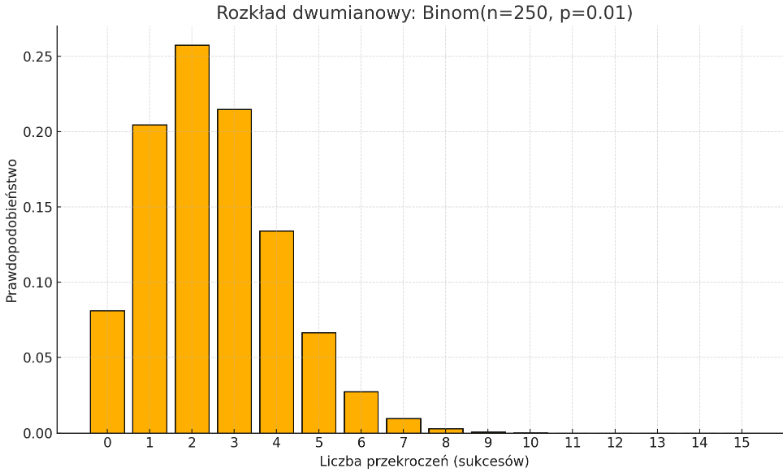


Testuje hipotezę zerową:  
$H_0: \pi = \alpha$

gdzie:  
- $\pi = \frac{x}{T}$ — zaobserwowana częstość przekroczeń,  
- $\alpha$ — nominalny poziom istotności (np. 0{,}01),  
- $x$ — liczba przekroczeń,  
- $T$ — liczba obserwacji.

Statystyka testowa (log-likelihood ratio):

$$
LR_{POF} = -2 \left[ \ln\left((1 - \alpha)^{T - x} \cdot \alpha^x\right) - \ln\left((1 - \pi)^{T - x} \cdot \pi^x\right) \right]
$$

Statystyka $LR_{POF}$ ma rozkład chi-kwadrat z 1 stopniem swobody:

$$
LR_{POF} \sim \chi^2(1)
$$

p-value:

$$
p = 1 - F_{\chi^2(1)}(LR_{POF})
$$


In [ ]:
# Parametry VaR
window = 250
alpha = 0.01

# Obliczenie historycznego VaR (rolling window)



In [ ]:
# Obliczanie przekroczeń (exceedences)


### Test Kupca (POF – Proportion of Failures)

gdzie:  
- $\pi = \frac{x}{T}$ — zaobserwowana częstość przekroczeń,  
- $\alpha$ — nominalny poziom istotności (np. 0{,}01),  
- $x$ — liczba przekroczeń,  
- $T$ — liczba obserwacji.

Statystyka testowa (log-likelihood ratio):

$$
LR_{POF} = -2 \left[ \ln\left((1 - \alpha)^{T - x} \cdot \alpha^x\right) - \ln\left((1 - \pi)^{T - x} \cdot \pi^x\right) \right]
$$

Statystyka $LR_{POF}$ ma rozkład chi-kwadrat z 1 stopniem swobody:

$$
LR_{POF} \sim \chi^2(1)
$$

p-value:

$$
p = 1 - F_{\chi^2(1)}(LR_{POF})
$$


In [ ]:
# Test kupca
from scipy.stats import chi2

# Parametry


# Proporcja 

# Log-likelihoods


# Statystyka Kupca


# Wynik



# Test Christoffersena (Independence test)

### Test Christoffersena – Niezależność przekroczeń (Independence Test)

#### 1. Prawdopodobieństwa przejść:

$$
\pi_{01} = \frac{n_{01}}{n_{00} + n_{01}}, \quad
\pi_{11} = \frac{n_{11}}{n_{10} + n_{11}}, \quad
\pi = \frac{n_{01} + n_{11}}{n_{00} + n_{01} + n_{10} + n_{11}}
$$

- $n_{ij}$ – liczba przejść od stanu $i$ do $j$, gdzie:
  - $i, j \in \{0, 1\}$
  - $0$ – brak przekroczenia (VaR nie został naruszony)
  - $1$ – przekroczenie (VaR został przekroczony)
- Przykłady:
  - $n_{01}$ – liczba przypadków, gdy dzień $t-1$ nie miał przekroczenia, a dzień $t$ miał
  - $n_{11}$ – liczba przypadków, gdy przekroczenia nastąpiły dwa dni z rzędu
- $\pi_{01}$ – prawdopodobieństwo przekroczenia po dniu bez przekroczenia
- $\pi_{11}$ – prawdopodobieństwo przekroczenia po dniu z przekroczeniem
- $\pi$ – bezwarunkowe prawdopodobieństwo przekroczenia


#### 2. Logarytmy funkcji wiarygodności:

**Model bez zależności (niezależność przekroczeń):**

$$
\log L_{\text{uncond}} =
(n_{00} + n_{10}) \cdot \log(1 - \pi) +
(n_{01} + n_{11}) \cdot \log(\pi)
$$

**Model warunkowy (zależność od poprzedniego dnia):**

$$
\log L_{\text{cond}} =
n_{00} \cdot \log(1 - \pi_{01}) +
n_{01} \cdot \log(\pi_{01}) +
n_{10} \cdot \log(1 - \pi_{11}) +
n_{11} \cdot \log(\pi_{11})
$$

#### 3. Statystyka testowa:

$$
LR_{\text{ind}} = -2 \left( \log L_{\text{uncond}} - \log L_{\text{cond}} \right)
$$

#### 4. Rozkład statystyki:

$$
LR_{\text{ind}} \sim \chi^2(1)
$$


Jeśli p-value wynosi np 0.002 (mniejsze od poziomu istotności) w teście Christoffersena, to oznacza, że istnieje bardzo silna przesłanka przeciwko hipotezie zerowej (H₀: przekroczenia VaR są zgodne z oczekiwaniami i niezależne w czasie)